# Precipitation

In [1]:
''' TODO:

''';

In [54]:
import os
import time
import torch
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
from matplotlib.ticker import FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.neighbors import kneighbors_graph

In [3]:
# use cuda if available
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device used: " + str(DEVICE))

Device used: cuda


### Parameters

In [52]:
# datasets path
DATAPATH = './data/aggregated_hourly_data.csv'
NB_NEIGHBORS = 3

# parameters related to datasets
LEN_TIME = 31
SYSTEM_DIM = np.array([20,20])  # dimension of input

# parameters of the loss
ALPHA1 = 1e-1
ALPHA2 = 1e-2
ALPHA_L2 = 1e-15

# training parameters
BATCH_SIZE = 256
HIDDEN_DIM = 128
LATENT_DIM = 512
LR = 1e-4


### Load dataset

In [38]:
agg_hourly_data = pd.read_csv(DATAPATH)

In [39]:
rain_data = agg_hourly_data.loc[:, ['date', 'rain', 'st_id', 'st_name','st_lat', 'st_long']]
rain_data.head()

,date,rain,st_id,st_name,st_lat,st_long
0,2007-12-31 02:00:00,0.0,175,phoenix_park,532149,62059
1,2007-12-31 03:00:00,0.0,175,phoenix_park,532149,62059
2,2007-12-31 04:00:00,0.0,175,phoenix_park,532149,62059
3,2007-12-31 05:00:00,0.0,175,phoenix_park,532149,62059
4,2007-12-31 06:00:00,0.0,175,phoenix_park,532149,62059


In [40]:
stations = rain_data.loc[:, ['st_id', 'st_name', 'st_lat', 'st_long']]
stations = stations.drop_duplicates().reset_index()

In [49]:
stations.head()

,index,st_id,st_name,st_lat,st_long
0,0,175,phoenix_park,532149,62059
1,123503,275,mace_head,531933,95403
2,247006,375,oak_park,525140,65455
3,370509,518,shannon_airport,524125,85505
4,494012,532,dublin_airport,532540,61427


In [55]:
graph = kneighbors_graph(stations.loc[:, ['st_lat', 'st_long']].values, NB_NEIGHBORS)

In [8]:
X_train, X_test, _, _ = train_test_split(full_ds, full_ds, test_size=0.2, random_state=42)

In [9]:
X_train.shape

(357, 31, 20, 20)

In [13]:
np.array(data).shape

(357, 31)

In [107]:
class CustomDataset(Dataset):
    '''
    Create the dataset from the time series contained in file_path
    '''
    def __init__(self, data):
        try:
            self.data = data
            self.targets = data
        except KeyError as e:
            print(e)
            return None
        else:
            print(f"Extracted {self.data.shape} data along with {self.targets.shape} targets")
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        input = self.data[idx]
        output = self.targets[idx]
        return input, output

In [ ]:
train_dataset = CustomDataset(X_train)
test_dataset = CustomDataset(DATA_PATH + 'FluidFlowOnAttractor_test_x.csv', LEN_TIME, SYSTEM_DIM)

Extracted (357, 31, 20, 20) data along with (357, 31, 20, 20) targets
Extracted (90, 31, 20, 20) data along with (90, 31, 20, 20) targets


In [ ]:
train_data = train_dataset.data
train_dataloader = DataLoader(
    dataset = train_dataset,
    batch_size = BATCH_SIZE,
    shuffle = False,
    num_workers = 0,
)

test_data = test_dataset.data
test_dataloader = DataLoader(
    dataset = test_dataset,
    batch_size = BATCH_SIZE,
    shuffle = False,
    num_workers = 0,
)

In [ ]:
train_data = train_dataset.data
train_dataloader = DataLoader(
    dataset = train_dataset,
    batch_size = BATCH_SIZE,
    shuffle = False,
    num_workers = 0
)

val_data = val_dataset.data
val_dataloader = DataLoader(
    dataset = val_dataset,
    batch_size = BATCH_SIZE,
    shuffle = False,
    num_workers = 0
)

test_data = test_dataset.data
test_dataloader = DataLoader(
    dataset = test_dataset,
    batch_size = BATCH_SIZE,
    shuffle = False,
    num_workers = 0
)

In [ ]:
class KoopmanCNet(nn.Module):
    '''
    Koopman convolutional network that encodes, advances in time and decodes
    
    params:
        system_dim -- initial system dimension
        hidden -- number of hidden units in each layer of the encoder and decoder
        latent_dim -- dimension of the approximated invariant Koopman subspace
    '''
    def __init__(self, system_dim, hidden, latent_dim):
        super(KoopmanNet, self).__init__()
                
        self.encode = nn.Sequential(
            nn.Linear(system_dim, hidden),
            nn.ELU(),
            nn.Linear(hidden, hidden),
            nn.ELU(),
            nn.Linear(hidden, latent_dim),
        )
        
        self.L = nn.Sequential(
            nn.Linear(latent_dim, latent_dim),
        )
        
        self.decode = nn.Sequential(
            nn.Linear(latent_dim, hidden),
            nn.ELU(),
            nn.Linear(hidden, hidden),
            nn.ELU(),
            nn.Linear(hidden, system_dim),
        )
        
    def forward(self, x):
        y = self.encode(x)
        x_recon = self.decode(y)
                
        y_lin = y[:,0,:].unsqueeze(dim=1)
        for i in range(x.shape[1]-1):
            y_prev = y_lin[:,-1,:].unsqueeze(dim=1)
            y_lin = torch.cat((y_lin, self.L(y_prev)), dim=1)
            
        x_pred = self.decode(y_lin)

        return x, x_recon, x_pred, y, y_lin

In [23]:
def define_loss(x, x_recon, x_pred, y, y_lin, target, alpha1, alpha2):
    
    # reconstruction loss
    recon_loss = alpha1 * F.mse_loss(x_recon, x)
    
    # linearity loss
    lin_loss = torch.tensor(0)
    lin_loss = F.mse_loss(y, y_lin)
    
    # prediction loss
    pred_loss = torch.tensor(0)
    pred_loss = alpha2 * torch.mean(PRED_WEIGHT*torch.linalg.norm(x_pred-x, dim=2)**2) # weighted MSE
    
    # total loss
    loss = recon_loss + pred_loss + lin_loss
    
    return loss, recon_loss, lin_loss, pred_loss

In [98]:
def define_loss(x, x_recon, x_pred, y, y_lin, target, alpha1, alpha2):
    
    # reconstruction loss
    recon_loss = alpha1 * F.mse_loss(x_recon, x)
    
    # linearity loss
    lin_loss = torch.tensor(0)
    lin_loss = F.mse_loss(y, y_lin)
    
    # prediction loss
    pred_loss = torch.tensor(0)
    #pred_loss = torch.mean(PRED_WEIGHT*torch.linalg.norm(x_pred-x, dim=2)**2) # weighted MSE
    pred_loss = alpha2*F.mse_loss(x, x_pred)
    
    # total loss
    loss = recon_loss + pred_loss + lin_loss
    
    return loss, recon_loss, lin_loss, pred_loss

### Training

In [12]:
model = KoopmanNet(system_dim=SYSTEM_DIM, hidden=HIDDEN_DIM,
                   latent_dim=LATENT_DIM).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=ALPHA_L2)
scheduler = StepLR(optimizer, step_size=20, gamma=0.95)

In [13]:
loss_epochs = []
recon_loss_epochs = []
lin_loss_epochs = []
pred_loss_epochs = []
val_loss = []

In [47]:
%%time

nb_epochs = 50

for epoch in range(nb_epochs):
    
    if(epoch % 10 == 0):
        print('Epoch {}'.format(epoch))
        
    running_loss = 0
    running_recon_loss = 0
    running_lin_loss = 0
    running_pred_loss = 0
    
    model.train()
    for batch_idx, (data, target) in enumerate(train_dataloader):
        data, target = data.to(DEVICE).float(), target.to(DEVICE).float()
        
        # reset gradients
        optimizer.zero_grad()

        # forward, backward, optimize
        x, x_recon, x_pred, y, y_lin = model(data)
        loss, recon_loss, lin_loss, pred_loss = define_loss(x, x_recon, x_pred, y, y_lin, 
                                                            target, ALPHA1, ALPHA2)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()*data.size(0)
        running_recon_loss += recon_loss.item()*data.size(0)
        running_lin_loss += lin_loss.item()*data.size(0)
        running_pred_loss += pred_loss.item()*data.size(0)
        
    # store running losses
    with torch.no_grad():
        loss_epochs.append(running_loss/len(train_dataloader))
        recon_loss_epochs.append(running_recon_loss/len(train_dataloader))
        lin_loss_epochs.append(running_lin_loss/len(train_dataloader))
        pred_loss_epochs.append(running_pred_loss/len(train_dataloader))
        
    val_loss.append(eval_model(model, val_dataloader))
    
    scheduler.step()

Epoch 0
Epoch 10
Epoch 20
Epoch 30
Epoch 40
Wall time: 12min 20s


### Plots

C:\Users\sjean\AppData\Local\Temp/ipykernel_22796/3589947100.py:11: RuntimeWarning: divide by zero encountered in log10
  axes[1, 1].plot(np.log10(pred_loss_epochs))


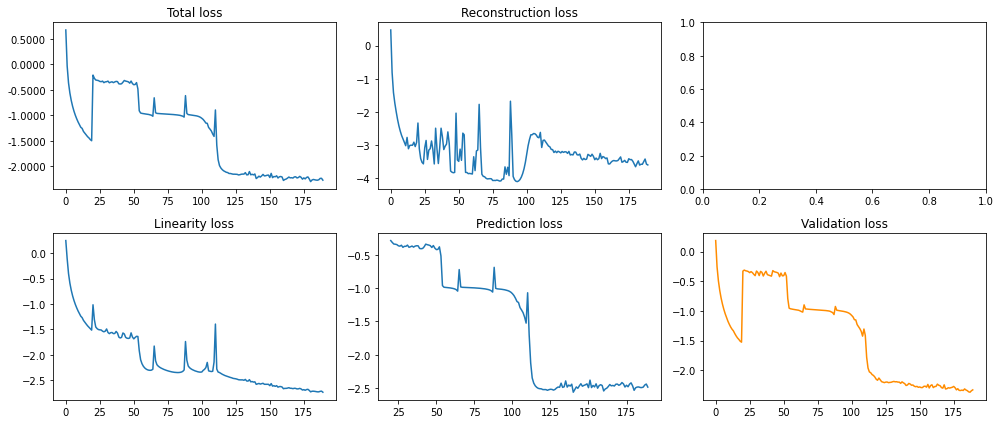

In [48]:
# plot training losses
fig, axes = plt.subplots(2, 3, figsize=(14,6))
axes[0, 0].plot(np.log10(loss_epochs))
axes[0, 0].set_title('Total loss')
#axes[0, 0].set_ylim(top=0)
axes[0, 1].plot(np.log10(recon_loss_epochs))
axes[0, 1].set_title('Reconstruction loss')
axes[1, 0].plot(np.log10(lin_loss_epochs))
axes[1, 0].set_title('Linearity loss')
#axes[1, 0].set_ylim(top=0)
axes[1, 1].plot(np.log10(pred_loss_epochs))
axes[1, 1].set_title('Prediction loss')
axes[1, 2].plot(np.log10(val_loss), color='darkorange')
axes[1, 2].set_title('Validation loss')

axes[0, 0].yaxis.set_major_formatter(FormatStrFormatter('%.4f'))

plt.tight_layout()
#plt.savefig('training_error.png')
plt.show()

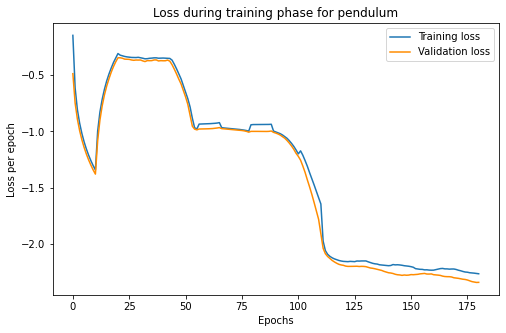

In [49]:
# smoothen the loss curve
width = 10 # smoothing factor
loss_epochs_smooth = np.convolve(loss_epochs, np.ones(width), 'valid') / width
val_loss_smooth = np.convolve(val_loss, np.ones(width), 'valid') / width

# plot loss
plt.subplots(figsize=(8,5))
plt.plot(np.log10(loss_epochs_smooth), label='Training loss')
plt.plot(np.log10(val_loss_smooth), color='darkorange', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss per epoch')
plt.title('Loss during training phase for pendulum')
plt.legend()
#plt.savefig('training_error_smooth.png')
plt.show()

### Model evaluation

In [50]:
training_error = eval_model(model, train_dataloader)
validation_error = eval_model(model, val_dataloader)

print(f'Training error:     {training_error:.12f}')
print(f'Validation error:   {validation_error:.12f}')

Training error:     0.004779106283
Validation error:   0.004691947373


### Trajectory simulation

In [51]:
# Load validation/test trajectories
with torch.no_grad():
    for data, target in val_dataloader:
        data, target = data.to(DEVICE).float(), target.to(DEVICE).float()

        output = model(data)
        x, x_recon, x_pred, y, y_lin = model(data)

In [52]:
x = np.array(x.detach().cpu())
x_recon = np.array(x_recon.detach().cpu())
x_pred = np.array(x_pred.detach().cpu())

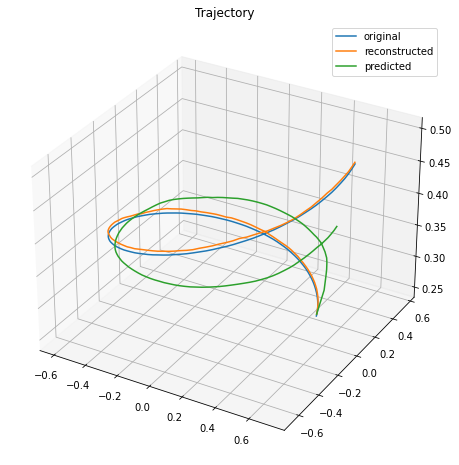

In [55]:
traj = 1
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(x[traj,:,0], x[traj,:,1], x[traj,:,2], label='original')#
ax.plot(x_recon[traj,:,0], x_recon[traj,:,1], x_recon[traj,:,2], label='reconstructed')
ax.plot(x_pred[traj,:,0], x_pred[traj,:,1], x_pred[traj,:,2], label='predicted')
plt.legend()
plt.title('Trajectory')
plt.show()

In [44]:
# load an example trajectory and apply the network
traj = np.loadtxt("./data/FluidFlowOnAttractor_traj_x.csv", delimiter=',')
x, x_recon, x_pred, y, y_lin = model(torch.unsqueeze(torch.tensor(traj[0:400,:]).float().to(DEVICE), dim=0))

In [45]:
x = np.array(x.detach().cpu())
x_recon = np.array(x_recon.detach().cpu())
x_pred = np.array(x_pred.detach().cpu())

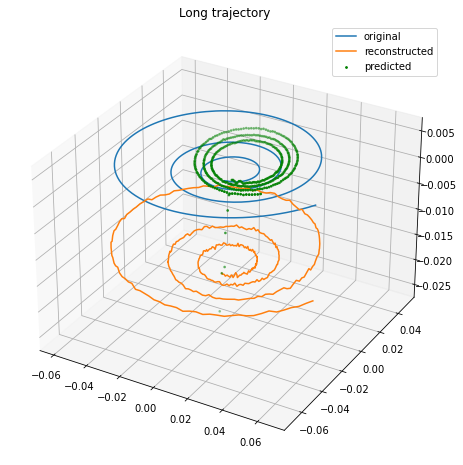

In [46]:
traj = 0
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(x[traj,:,0], x[traj,:,1], x[traj,:,2], label='original')
ax.plot(x_recon[traj,:,0], x_recon[traj,:,1], x_recon[traj,:,2], label='reconstructed')
ax.scatter(x_pred[traj,:,0], x_pred[traj,:,1], x_pred[traj,:,2], s=3, label='predicted', color='green')
plt.legend()
plt.title('Long trajectory')
plt.show()

In [18]:
PATH = './models/fluidflow_model_128_512.pt'

In [19]:
#torch.save(model.state_dict(), PATH)

In [20]:
model = KoopmanNet(system_dim=SYSTEM_DIM, hidden=HIDDEN_DIM,
                   latent_dim=LATENT_DIM).to(DEVICE)
model.load_state_dict(torch.load(PATH, map_location=DEVICE))

RuntimeError: Error(s) in loading state_dict for KoopmanNet:
	Missing key(s) in state_dict: "L.0.weight", "L.0.bias", "L.1.weight", "L.1.bias", "L.2.weight", "L.2.bias". 
	Unexpected key(s) in state_dict: "L.weight", "L.bias". 

In [77]:
np.save('./loss.npy', loss_epochs)